# User Segmentation Analysis
This notebook performs user segmentation analysis on the marketing campaign dataset. It includes data loading, cleaning, feature engineering, exploratory data analysis (EDA), and clustering using PCA and KMeans.


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from matplotlib.gridspec import GridSpec

## 1. Load the Dataset
Load the marketing campaign dataset and display the first few rows to understand its structure.

In [60]:
# Load the dataset
def load_data(filepath):
    return pd.read_csv(filepath, delimiter='\t')

data = load_data('marketing_campaign.csv')

# Display first few rows to understand the data
print("Initial Data:")
print(data.head())

Initial Data:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0

## 2. Data Cleaning
Clean the dataset by handling missing values, removing duplicates, and formatting date variables.

In [62]:
# Separate numerical and categorical columns
def separate_columns(data):
    numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()
    categorical_columns = data.select_dtypes(exclude=[np.number]).columns.tolist()
    return numerical_columns, categorical_columns

numerical_columns, categorical_columns = separate_columns(data)

# Remove constant columns
def remove_constant_columns(data, numerical_columns, categorical_columns):
    variance = data[numerical_columns].var()
    constant_num_columns = variance[variance == 0].index
    constant_cat_columns = [col for col in categorical_columns if data[col].nunique() == 1]
    constant_columns = list(constant_num_columns) + constant_cat_columns
    data.drop(columns=constant_columns, inplace=True)
    return data

data = remove_constant_columns(data, numerical_columns, categorical_columns)

# Update the numerical and categorical columns list
numerical_columns, categorical_columns = separate_columns(data)

# Handle missing values
def handle_missing_values(data, numerical_columns, categorical_columns):
    data['Income'] = data.groupby('Education')['Income'].transform(lambda x: x.fillna(x.median()))
    data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())
    for col in categorical_columns:
        data[col].fillna(data[col].mode()[0], inplace=True)
    return data

data = handle_missing_values(data, numerical_columns, categorical_columns)

# Remove duplicates
def remove_duplicates(data):
    data.drop_duplicates(inplace=True)
    return data

data = remove_duplicates(data)

# Format date variables
def format_date(data, date_column):
    data[date_column] = pd.to_datetime(data[date_column], format='%d-%m-%Y')
    return data

data = format_date(data, 'Dt_Customer')

## 3. Exploratory Data Analysis (EDA)
Analyze the data to understand the distribution of categorical variables and perform feature engineering.

In [65]:
# Display value counts for categorical columns
def display_value_counts(data, categorical_columns):
    print("Value counts for categorical columns:")
    for col in categorical_columns:
        if col != 'Dt_Customer':
            print(data[col].value_counts())

display_value_counts(data, categorical_columns)

Value counts for categorical columns:
Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64
Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


In [66]:
# Feature engineering
def feature_engineering(data):
    max_date = data['Dt_Customer'].max()
    data['Customer_Since'] = (max_date - data['Dt_Customer']).dt.days
    data['Age'] = 2014 - data['Year_Birth']
    data['Total_Spent'] = data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
    data['Total_Purchases'] = data[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)
    data['Total_AcceptedCmp'] = data[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)
    data['Education_Level'] = data['Education'].replace({'Basic': 'Low', '2n Cycle': 'High', 'Graduation': 'Medium', 'Master': 'High', 'PhD': 'High'})
    data["Living_With"] = data["Marital_Status"].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Alone", "Widow": "Alone", "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"})
    data["Children"] = data["Kidhome"] + data["Teenhome"]
    data["Is_Parent"] = np.where(data["Children"] > 0, 1, 0)
    data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner": 2}) + data["Children"]
    return data

data = feature_engineering(data)

# Dropping some of the redundant features
def drop_redundant_features(data, columns_to_drop):
    data.drop(columns=columns_to_drop, inplace=True)
    return data

to_drop = ["Marital_Status", "Dt_Customer", "Year_Birth", "ID", "Education"]
data = drop_redundant_features(data, to_drop)

# Display the first few rows after preprocessing
print("Data after preprocessing:")
print(data.describe())

Data after preprocessing:
              Income      Kidhome     Teenhome      Recency     MntWines  \
count    2240.000000  2240.000000  2240.000000  2240.000000  2240.000000   
mean    52242.594866     0.444196     0.506250    49.109375   303.935714   
std     25039.061738     0.538398     0.544538    28.962453   336.597393   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35538.750000     0.000000     0.000000    24.000000    23.750000   
50%     51498.500000     0.000000     0.000000    49.000000   173.500000   
75%     68289.750000     1.000000     1.000000    74.000000   504.250000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

         MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
count  2240.000000      2240.000000      2240.000000       2240.000000   
mean     26.302232       166.950000        37.525446         27.062946   
std      39.773434       225.715373        54.628979         41.280

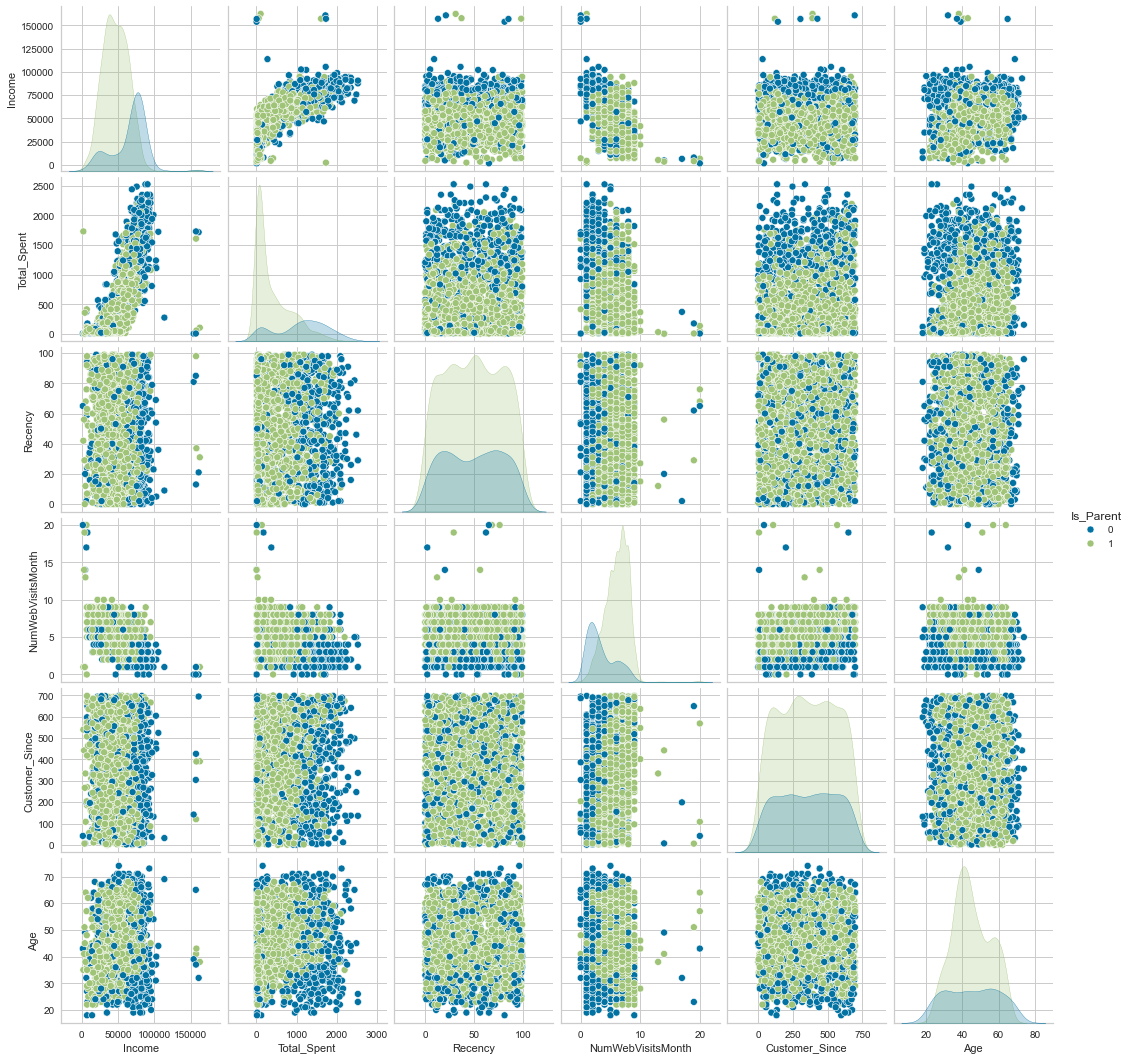

In [96]:
# Create the pairplot
# Features to include in the pairplot
features = ["Income", "Total_Spent", "Recency", "NumWebVisitsMonth","Customer_Since", "Age", "Is_Parent"]
sns.pairplot(data[features], hue="Is_Parent")
plt.show()

<AxesSubplot:>

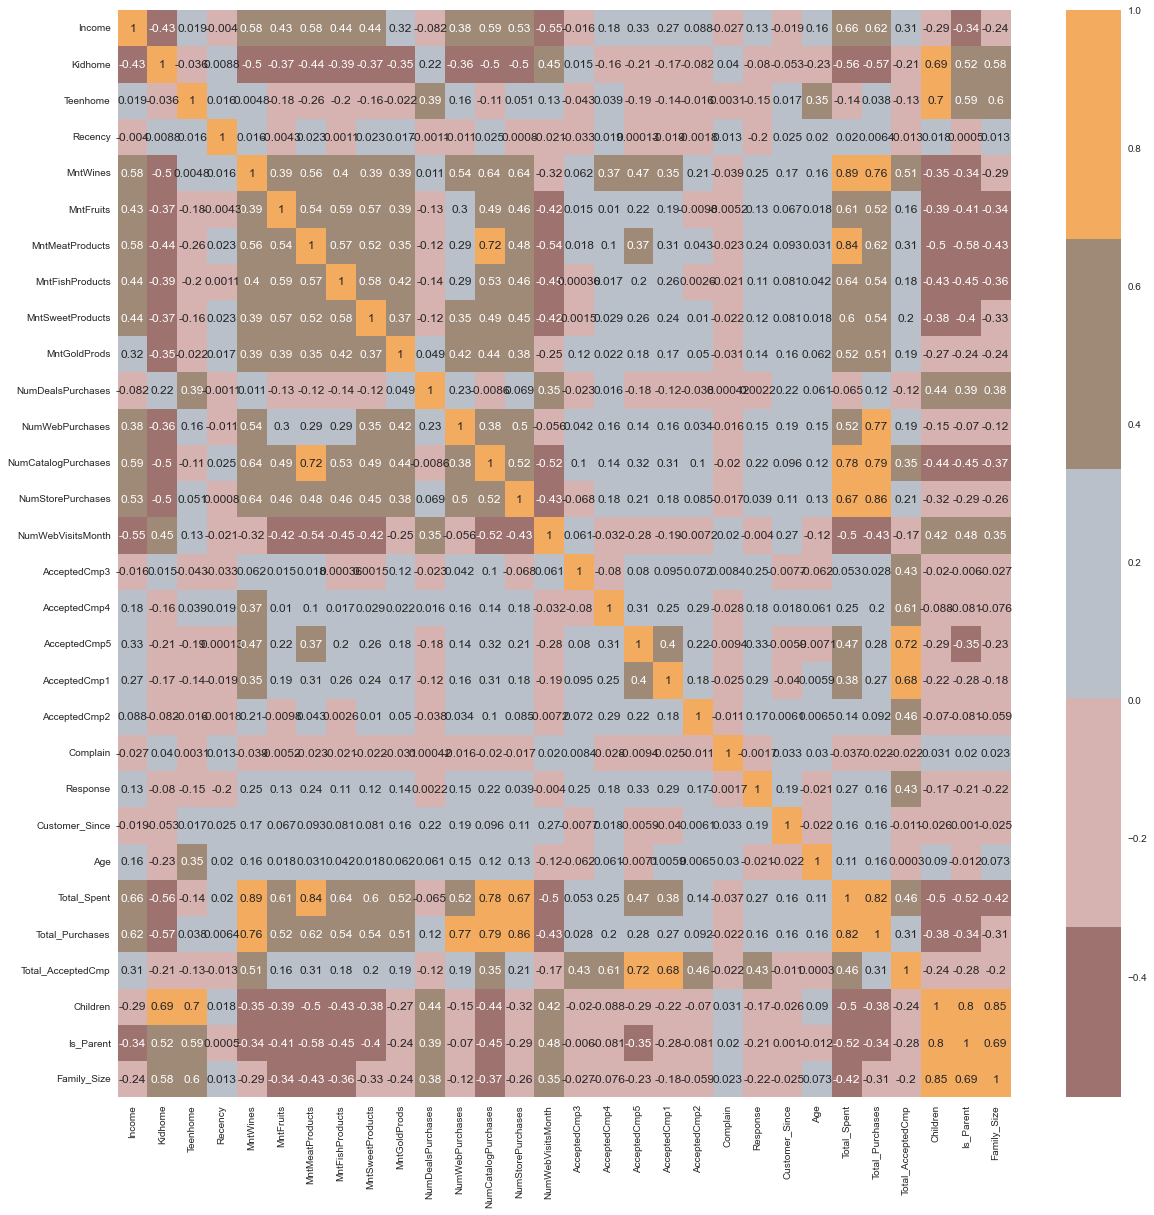

In [68]:
#correlation matrix
# Update the numerical and categorical columns list
numerical_columns, categorical_columns = separate_columns(data)
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
corrmat= data[numerical_columns].corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

## 5. Outlier Removal and Scaling
Remove outliers and scale the numerical features for PCA.

In [77]:
# Remove outliers
def remove_outliers(data):
    return data[(data['Age'] < 100) & (data['Income'] < 600000)].reset_index(drop=True)

data = remove_outliers(data)

# Calculate VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["features"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif = calculate_vif(data[numerical_columns])
print("VIF:\n", vif)

VIF:
                features        VIF
0                Income  22.189951
1               Kidhome        inf
2              Teenhome        inf
3               Recency   3.948964
4              MntWines        inf
5             MntFruits        inf
6       MntMeatProducts        inf
7       MntFishProducts        inf
8      MntSweetProducts        inf
9          MntGoldProds        inf
10    NumDealsPurchases   4.135560
11      NumWebPurchases        inf
12  NumCatalogPurchases        inf
13    NumStorePurchases        inf
14    NumWebVisitsMonth  12.223993
15         AcceptedCmp3        inf
16         AcceptedCmp4        inf
17         AcceptedCmp5        inf
18         AcceptedCmp1        inf
19         AcceptedCmp2        inf
20             Complain   1.016029
21             Response   1.743407
22       Customer_Since   5.487535
23                  Age  15.537000
24          Total_Spent        inf
25      Total_Purchases        inf
26    Total_AcceptedCmp        inf
27            

/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [79]:
# Function to encode categorical features
def encode_categorical_features(data, categorical_columns, sequential_features):
    # Separate categorical columns that are not sequential
    non_sequential_features = [col for col in categorical_columns if col not in sequential_features]

    # Apply LabelEncoder to sequential features
    label_encoders = {}
    for feature in sequential_features:
        le = LabelEncoder()
        data[feature] = le.fit_transform(data[feature])
        label_encoders[feature] = le
    if non_sequential_features == []:
        return data
    else:
        # Apply OneHotEncoder to non-sequential features
        ohe = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid multicollinearity
        encoded_features = ohe.fit_transform(data[non_sequential_features])
        encoded_feature_names = ohe.get_feature_names_out(non_sequential_features)

        # Create a DataFrame with the encoded features and concatenate with the original data
        encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)
        data = pd.concat([data, encoded_df], axis=1)
        
        # Drop the original non-sequential categorical columns
        data.drop(columns=non_sequential_features, inplace=True)

    return data

data = encode_categorical_features(data, categorical_columns, ['Education_Level'])

# Scale the data
def scale_data(data, columns_to_drop):
    ds = data.copy()
    ds.drop(columns=columns_to_drop, inplace=True)
    scaler = StandardScaler()
    ds_scaled = scaler.fit_transform(ds)
    ds_scaled = pd.DataFrame(ds_scaled, columns=ds.columns)
    return ds_scaled

columns_to_drop = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
ds_scaled = scale_data(data, columns_to_drop)

/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 6. Principal Component Analysis (PCA)
Reduce dimensions using PCA and visualize the data in 3D.

In [81]:
# Perform PCA
def perform_pca(data, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    pca_data = pd.DataFrame(pca.transform(data), columns=[f"PC{i+1}" for i in range(n_components)])
    return pca_data

PCA_data = perform_pca(ds_scaled, 3)
PCA_data.describe()

,PC1,PC2,PC3
count,2.236000e+03,2.236000e+03,2236.000000
mean,2.097309e-16,1.906644e-17,0.000000
std,3.019438e+00,1.757863e+00,1.238528
min,-6.120705e+00,-4.314961e+00,-3.703311
25%,-2.741861e+00,-1.364157e+00,-0.841564
50%,-8.036724e-01,-2.020654e-01,-0.027443
75%,2.570899e+00,1.262763e+00,0.864313
max,8.147331e+00,6.251512e+00,6.616771


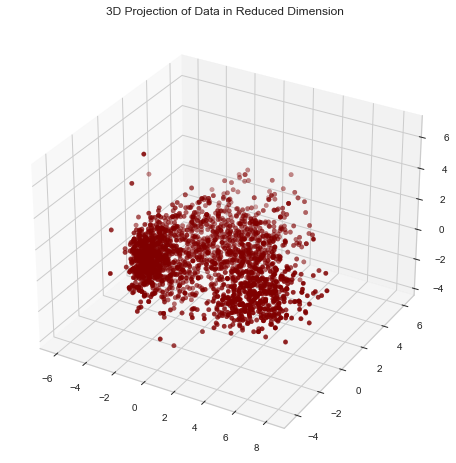

In [82]:
# ### 3D Projection of Data in Reduced Dimension
# 3D Projection
def plot_3d_projection(data, x_col, y_col, z_col, title):
    x, y, z = data[x_col], data[y_col], data[z_col]
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x, y, z, c="maroon", marker="o")
    ax.set_title(title)
    plt.show()

plot_3d_projection(PCA_data, "PC1", "PC2", "PC3", "3D Projection of Data in Reduced Dimension")

## 7. Clustering with KMeans
Use the elbow method to determine the optimal number of clusters and apply KMeans clustering.
- Distortion Score (Blue Line)  
    - Description: The distortion score (also known as the sum of squared distances or inertia) measures the compactness of the clusters. It is the sum of squared distances from each point to its assigned cluster center.  
    - Interpretation:  
        The distortion score decreases as the number of clusters (k) increases.  
        The goal is to find the "elbow point" where the distortion score stops decreasing significantly with the addition of more clusters. This point indicates the optimal number of clusters.  
- Silhouette Score:
Measures how similar each point is to its own cluster compared to other clusters.  
Higher Silhouette Score indicates better-defined clusters.  
- Davies-Bouldin Index:
Measures the average similarity ratio of each cluster with the cluster that is most similar to it.  
Lower Davies-Bouldin Index indicates better-defined clusters.

Based on the evaluation metrics:

1. **Elbow Method** suggests \( k = 4 \) as the optimal number of clusters due to a significant drop in the distortion score, but \( k = 3 \) also shows a considerable decrease and could be a simpler solution.
2. **Silhouette Score** and **Davies-Bouldin Index** suggest \( k = 2 \) for the highest cluster quality, but \( k = 3 \) offers a better balance than \( k = 4 \).

**Recommendation**:
- **Balanced Choice**: \( k = 3 \) provides a good balance between segmentation detail and cluster quality.
- If practical needs require more detailed segmentation, \( k = 4 \) can be considered.
- If the highest cluster quality is essential and fewer segments are acceptable, \( k = 2 \) is better.

Overall, \( k = 3 \) is recommended as a balanced choice that maintains good cluster quality while providing sufficient segmentation granularity.

Elbow Method to determine the number of clusters to be formed:


/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kme

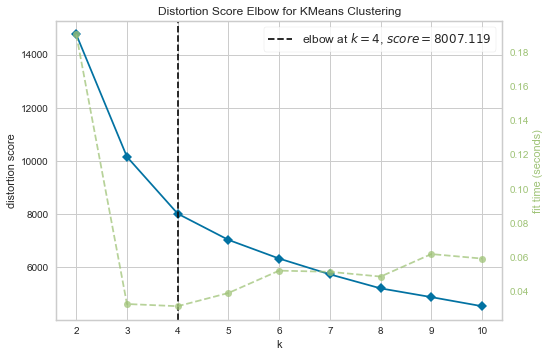

/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, Silhouette Score = 0.45365664352706647, Davies-Bouldin Index = 0.8924959473008822
For n_clusters = 3, Silhouette Score = 0.4245775228182017, Davies-Bouldin Index = 0.8987614600459488


/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, Silhouette Score = 0.37284673719133865, Davies-Bouldin Index = 0.993902129122706
For n_clusters = 5, Silhouette Score = 0.3420406081645233, Davies-Bouldin Index = 1.093123080390786


/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6, Silhouette Score = 0.3425414013184262, Davies-Bouldin Index = 1.0866261346641666
For n_clusters = 7, Silhouette Score = 0.35268728823044565, Davies-Bouldin Index = 1.0376912197993302


/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8, Silhouette Score = 0.30615526394943293, Davies-Bouldin Index = 1.149052577961101
For n_clusters = 9, Silhouette Score = 0.29390541156232247, Davies-Bouldin Index = 1.1823143352360883


/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10, Silhouette Score = 0.2857032883151639, Davies-Bouldin Index = 1.0838366759303792


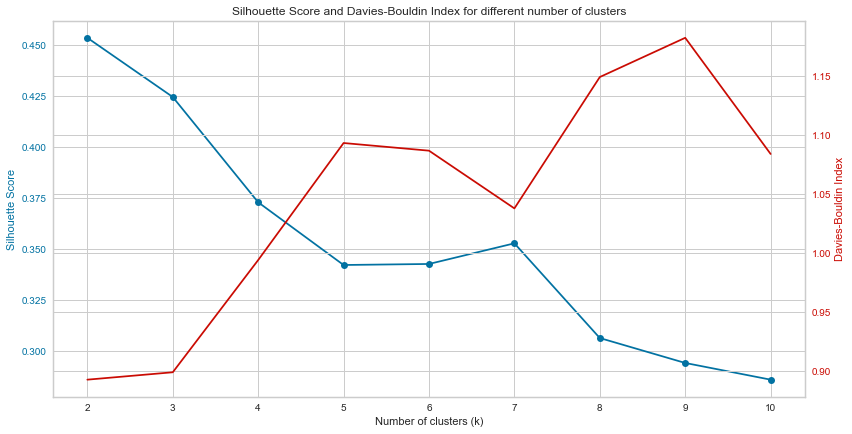

In [84]:
# Elbow Method to determine the number of clusters
def elbow_method(data, k_range):
    print('Elbow Method to determine the number of clusters to be formed:')
    elbow_visualizer = KElbowVisualizer(KMeans(), k=k_range)
    elbow_visualizer.fit(data)
    elbow_visualizer.show()

# Supplement with Silhouette Score and Davies-Bouldin Index
def evaluate_clustering(data, k_range):
    silhouette_scores = []
    davies_bouldin_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0)
        clusters = kmeans.fit_predict(data)
        
        silhouette_avg = silhouette_score(data, clusters)
        silhouette_scores.append(silhouette_avg)
        
        davies_bouldin_avg = davies_bouldin_score(data, clusters)
        davies_bouldin_scores.append(davies_bouldin_avg)
        
        print(f"For n_clusters = {k}, Silhouette Score = {silhouette_avg}, Davies-Bouldin Index = {davies_bouldin_avg}")

    # Plotting the scores
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(k_range, silhouette_scores, 'b-', marker='o', label='Silhouette Score')
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Silhouette Score', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(k_range, davies_bouldin_scores, 'r-', marker='x', label='Davies-Bouldin Index')
    ax2.set_ylabel('Davies-Bouldin Index', color='r')
    ax2.tick_params('y', colors='r')

    fig.tight_layout()
    plt.title('Silhouette Score and Davies-Bouldin Index for different number of clusters')
    plt.show()

# Determine the number of clusters using the Elbow Method
elbow_method(PCA_data, range(2, 11))

# Evaluate clustering using Silhouette Score and Davies-Bouldin Index
evaluate_clustering(PCA_data, range(2, 11))

## 8. Applying KMeans and Analyzing Clusters

/Users/ellenyan/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


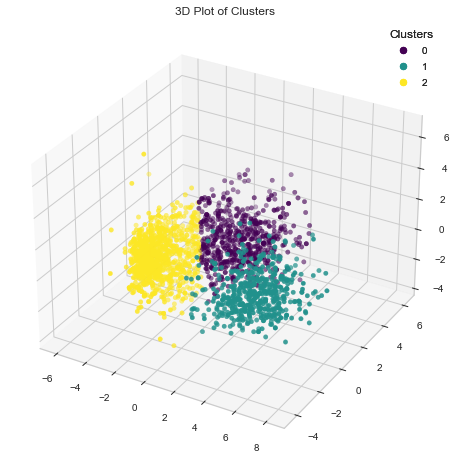

In [86]:
# Apply KMeans
def apply_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(data)
    data["Clusters"] = clusters
    return data, clusters

PCA_data, clusters = apply_kmeans(PCA_data, 3)
data["Clusters"] = clusters

# Plotting the clusters in 3D
def plot_clusters_3d(data, x_col, y_col, z_col, title):
    x, y, z = data[x_col], data[y_col], data[z_col]
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=data["Clusters"], cmap='viridis', marker='o')
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.set_title(title)
    plt.show()

plot_clusters_3d(PCA_data, "PC1", "PC2", "PC3", "3D Plot of Clusters")

## 9. Visualizing and Validating Cluster Distributions

### 9.1 Cluster Distribution
- Overall Insights
    - Cluster Distribution  
        - Cluster 2 is the largest cluster, making up almost half of all customers, indicating that the majority of customers have lower incomes and spending.  
        - Cluster 0 and Cluster 1 are relatively smaller, each comprising about a quarter of the total customer base, with Cluster 0 being slightly larger than Cluster 1.  
    - Income and Spending Profiles  
        - Cluster 0: This cluster is diverse, with customers spread across different income and spending levels, with the majority belonging to mid-income and mid-spending.  
        - Cluster 1: This cluster has customers with moderate to high income and spending. These customers are likely more affluent and have higher purchasing power.  
        - Cluster 2: This cluster is tightly grouped around low income and low spending, indicating a large segment of lower-income, lower-spending customers.
- Actionable Insights  
    - Cluster 1: Focus on premium products and high-value services, as this cluster has higher income and spending.  
    Tailor marketing campaigns to highlight luxury items and exclusive deals.
    - Cluster 2: Offer value-for-money products and budget-friendly options, as this cluster has lower income and spending.  
Use discounts, promotions, and loyalty programs to attract and retain these customers.

/var/folders/gt/nykzrg6x129dryx71cktw8t00000gn/T/ipykernel_32299/2818635318.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x, hue=hue, data=data, palette=palette)


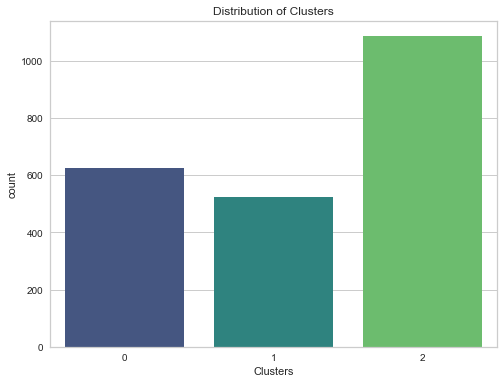

In [99]:
# Generic plot function
def plot_generic(data, x, y=None, hue=None, kind="count", title=None, palette='viridis'):
    plt.figure(figsize=(8, 6))
    if kind == "count":
        sns.countplot(x=x, hue=hue, data=data, palette=palette)
    elif kind == "boxen":
        sns.boxenplot(x=x, y=y, data=data, palette=palette)
    elif kind == "violin":
        sns.violinplot(x=x, y=y, data=data, palette=palette)
    elif kind == "scatter":
        sns.scatterplot(x=x, y=y, hue=hue, data=data, palette=palette)
    elif kind == "bar":
        sns.barplot(x=x, y=y, hue=hue, data=data, palette=palette)
    plt.title(title)
    plt.show()

# Plotting countplot of clusters
plot_generic(data, x="Clusters", kind="count", title="Distribution of Clusters")

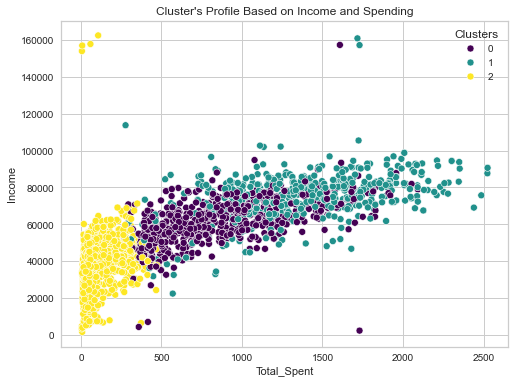

In [88]:
# ### Income & Spending
plot_generic(data, x="Total_Spent", y="Income", hue="Clusters", kind="scatter", title="Cluster's Profile Based on Income and Spending")

### 9.1 Product Preference
- Overall Insights
    - Top Product Preferences: MntWines and MntMeatProducts are the top two choices among all clusters, but the degree of preference varies.
    - Cluster 0: 60% preference for wines and 20% preference for meat products
    - Cluster 1: More balanced preference: 44% for wines and 33% for meat products, followed by fish at 7%
    - Cluster 2: More diversified preference: 44% for wines, 23% for meat products, and 15% for gold products
- Actionable Insights
    - Cluster 0: Emphasize marketing campaigns for wines and, to a lesser extent, meat products.
    - Cluster 1: Balance marketing efforts between wines and meat products.
    - Cluster 2: Highlight wines, meat, and gold products in marketing campaigns.

In [95]:
# ### Spending Distribution by Product Category
# Prepare data for product category distribution
def prepare_melted_data(data):
    melted_data = pd.melt(data, id_vars=['Clusters'], 
                          value_vars=['MntWines', 'MntFruits', 'MntMeatProducts', 
                                      'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'],
                          var_name='Product', value_name='Amount')
    cluster_totals = melted_data.groupby('Clusters')['Amount'].sum()
    melted_data['Percentage'] = melted_data.apply(lambda x: (x['Amount'] / cluster_totals[x['Clusters']]) * 100, axis=1)
    return melted_data

melted_data = prepare_melted_data(data)

# generate a summary table
product_summary = melted_data.groupby(['Clusters','Product'])[['Amount','Percentage']].sum().sort_values(by=['Clusters','Amount'], ascending=[True,False])
print(product_summary)

# # Plot spending distribution by product category
# def plot_product_distribution(melted_data):
#     fig = plt.figure(figsize=(18, 14))
#     gs = GridSpec(2, 1)
    
#     # Boxen plot for total spending per cluster
#     ax1 = fig.add_subplot(gs[0, 0])
#     sns.boxenplot(x='Clusters', y='Total_Spent', palette='viridis', data=data, ax=ax1)
#     ax1.set_title("Total Spending Distribution per Cluster")
#     ax1.set_xlabel('Clusters')
#     ax1.set_ylabel('Total Spent')
    
#     # Bar plot for product category distribution per cluster
#     ax2 = fig.add_subplot(gs[1, 0])
#     sns.histplot(data=melted_data, x='Clusters', hue='Product', weights='Percentage', 
#                  multiple='stack', palette='muted', shrink=0.8, ax=ax2)
#     ax2.set_title('Distribution of Product Categories in Each Cluster')
#     ax2.set_xlabel('Clusters')
#     ax2.set_ylabel('Percentage')
#     ax2.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    
#     plt.tight_layout()
#     plt.show()

# plot_product_distribution(melted_data)

                           Amount  Percentage
Clusters Product                             
0        MntWines          311354   59.465571
         MntMeatProducts   105509   20.151188
         MntGoldProds       41919    8.006119
         MntFishProducts    25355    4.842557
         MntSweetProducts   20083    3.835657
         MntFruits          19367    3.698908
1        MntWines          316635   44.261278
         MntMeatProducts   240744   33.652745
         MntFishProducts    50410    7.046634
         MntGoldProds       38954    5.445241
         MntSweetProducts   34834    4.869321
         MntFruits          33800    4.724781
2        MntWines           52040   44.853562
         MntMeatProducts    27122   23.376601
         MntGoldProds       17473   15.060075
         MntFishProducts     8166    7.038320
         MntSweetProducts    5635    4.856837
         MntFruits           5586    4.814604


### 9.2 Purchase Location Preference
- Overall Insights 
    - Most Popular Location: The most popular purchase location across all clusters is the store.
    - Cluster 0 and 2: Web purchases are a promising second choice for Clusters 0 and 2, with a close preference to stores.
    - Cluster 1: This cluster has a more balanced location choice, with the second choice being catalog purchases.
- Actionable Insights
    - Meet Current Needs
        - Clusters 0 and 2: 
            - Enhance in-store and online shopping experiences. 
            - Focus on digital marketing campaigns and in-store promotions.
        - Cluster 1:
            - Invest in both catalog and in-store shopping experiences.
            - Use catalog marketing and in-store exclusive deals to attract this segment.
- For Future Transformation (Boost Web Purchases)
    - Develop strategies to increase web purchases across all clusters, especially focusing on Clusters 0 and 2, where web purchases are already a significant - second choice.
    - Implement targeted online promotions, user-friendly website improvements, and personalized digital marketing to encourage more online shopping.

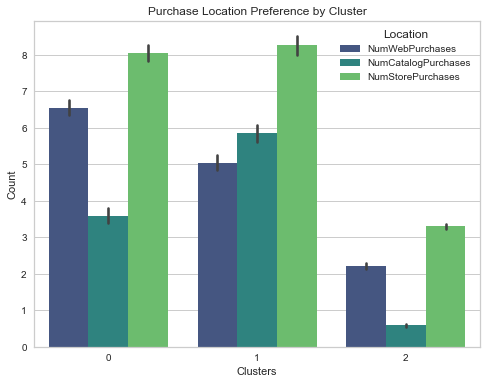

In [100]:
# Prepare data for purchase locations
def prepare_location_data(data):
    loc_data = pd.melt(data, id_vars=['Clusters'], 
                       value_vars=['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'],
                       var_name='Location', value_name='Count')
    cluster_totals = loc_data.groupby('Clusters')['Count'].sum()
    loc_data['Percentage'] = loc_data.apply(lambda x: (x['Count'] / cluster_totals[x['Clusters']]) * 100, axis=1)
    return loc_data

loc_data = prepare_location_data(data)

# Plot purchase location preference
plot_generic(loc_data, x='Clusters', y='Count', hue='Location', kind='bar', title="Purchase Location Preference by Cluster")

### 9.3 Deal Preference
- Overall insights:
    - Cluster 0: This cluster has a diverse approach to deal purchases. Marketing strategies should include a mix of regular and deal-based promotions to cater to this variability.
    - Cluster 1: This cluster shows the least interest in deals. Marketing strategies should focus more on product quality and brand value rather than discounts.
    - Cluster 2: This cluster is highly motivated by deals. Aggressive deal-based marketing strategies and promotions will likely be most effective.

/var/folders/gt/nykzrg6x129dryx71cktw8t00000gn/T/ipykernel_32299/558504985.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Clusters', y='DealPerc', data=data, palette='viridis')


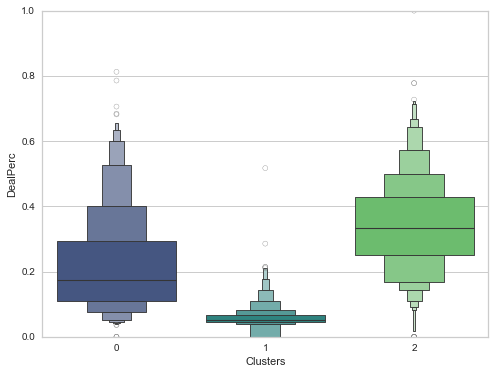

In [103]:
# Plot percentage of deals purchased per cluster
data['DealPerc'] = data['NumDealsPurchases'] / data['Total_Purchases']
plt.figure(figsize=(8, 6))
sns.boxenplot(x='Clusters', y='DealPerc', data=data, palette='viridis')
plt.ylim(0, 1)
plt.show()

In [105]:
data[data['DealPerc']<=1].groupby('Clusters')['DealPerc'].describe()

,count,mean,std,min,25%,50%,75%,max
Clusters,,,,,,,,
0,624.0,0.218889,0.151034,0.0,0.111111,0.173913,0.294118,0.812500
1,525.0,0.059983,0.038497,0.0,0.045455,0.052632,0.066667,0.517241
2,1080.0,0.342311,0.144832,0.0,0.250000,0.333333,0.428571,1.000000


### 9.4. Interaction Analysis
Analyze interaction features and personal features to gain more insights into customer segments.
- Overall Insights 
    - Customer Tenure:
        - Cluster 0 has the longest average customer tenure with a broad range, indicating diverse customer retention.
        - Cluster 2 has a more concentrated and slightly shorter customer tenure.
        - Cluster 1 is intermediate in customer tenure.
    - Web Engagement:
        - Cluster 2 shows the highest web engagement, followed by Cluster 0.
        - Cluster 1 has the lowest web engagement, indicating less frequent online activity.

/var/folders/gt/nykzrg6x129dryx71cktw8t00000gn/T/ipykernel_32299/2818635318.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=x, y=y, data=data, palette=palette)


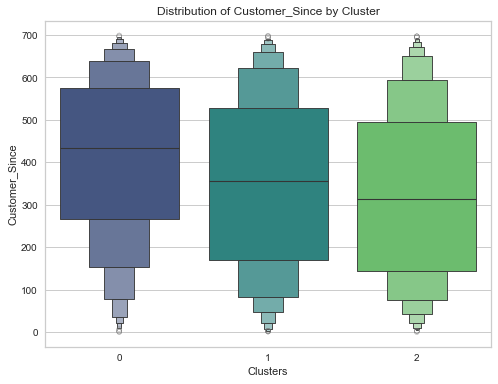

           count        mean         std  min    5%    10%    25%    50%  \
Clusters                                                                   
0          624.0  409.410256  191.811659  0.0  58.0  119.3  265.5  434.0   
1          525.0  348.740952  206.982154  1.0  37.0   62.0  170.0  355.0   
2         1087.0  324.264949  199.214257  0.0  37.3   63.2  144.5  313.0   

             75%    90%     95%    max  
Clusters                                
0         576.25  654.4  673.85  699.0  
1         528.00  642.0  667.80  698.0  
2         494.00  609.0  661.00  697.0  


/var/folders/gt/nykzrg6x129dryx71cktw8t00000gn/T/ipykernel_32299/2818635318.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=x, y=y, data=data, palette=palette)


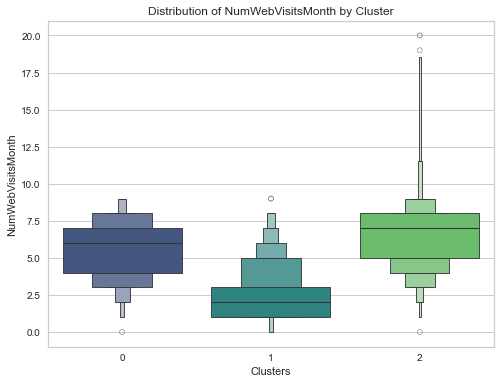

/var/folders/gt/nykzrg6x129dryx71cktw8t00000gn/T/ipykernel_32299/2818635318.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=x, y=y, data=data, palette=palette)


           count      mean       std  min   5%  10%  25%  50%  75%  90%  95%  \
Clusters                                                                       
0          624.0  5.552885  1.891204  0.0  2.0  3.0  4.0  6.0  7.0  8.0  8.0   
1          525.0  2.727619  1.812830  0.0  1.0  1.0  1.0  2.0  3.0  6.0  6.0   
2         1087.0  6.436063  1.989222  0.0  3.0  4.0  5.0  7.0  8.0  8.0  9.0   

           max  
Clusters        
0          9.0  
1          9.0  
2         20.0  


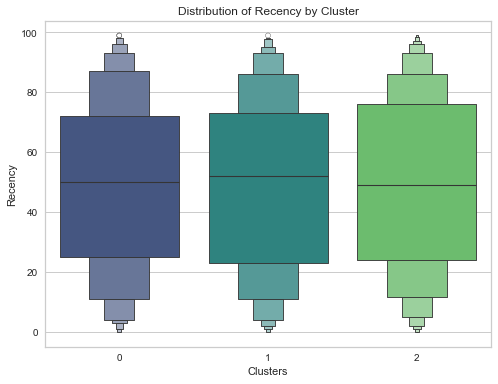

           count       mean        std  min   5%   10%   25%   50%   75%  \
Clusters                                                                   
0          624.0  49.041667  28.620866  0.0  4.0   9.0  25.0  50.0  72.0   
1          525.0  49.114286  29.280401  0.0  3.0   8.4  23.0  52.0  73.0   
2         1087.0  49.160074  29.018889  0.0  4.0  10.0  24.0  49.0  76.0   

           90%   95%   max  
Clusters                    
0         89.7  94.0  99.0  
1         89.0  94.0  99.0  
2         89.0  94.0  99.0  


In [118]:
# Plot interaction features
def plot_features(data, features, plot_type="violin"):
    for feature in features:
        plot_generic(data, x="Clusters", y=feature, kind=plot_type, title=f"Distribution of {feature} by Cluster")
        print(data.groupby('Clusters')[feature].describe(percentiles=[0.1, 0.05, 0.25, 0.5, 0.75, 0.9, 0.95]))

interaction_features = ["Customer_Since", "NumWebVisitsMonth", "Recency"]
plot_features(data, interaction_features, plot_type="boxen")

### 9.4 Personal Features
- Overall Insights
    - Age Distribution:
        - Cluster 0: Almost no young customers under 30, but a balanced distribution between middle-aged (30-50) and older (above 50) customers.
        - Cluster 1: Balanced representation across all age groups, with no single age group dominating.
        - Cluster 2: Mostly middle-aged (30-50), with a substantial number of older customers (above 50) and a significant portion of younger customers (18-30).
    - Family Structure:
        - Cluster 0: Dominated by couples with 1 kid and single parents with 1 kid.
        - Cluster 1: Primarily consists of couples with no kids and single persons with no kids.
        - Cluster 2: Diverse mix of family structures, with significant proportions of both couples and single parents with varying numbers of kids.

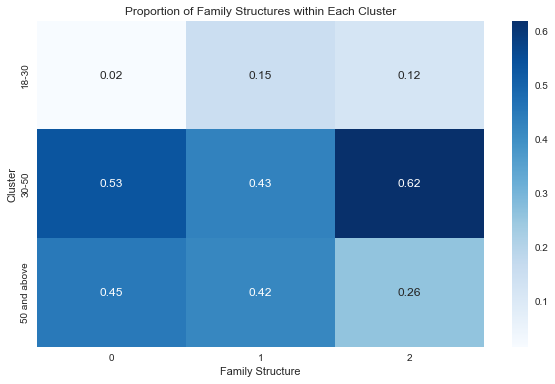

In [128]:
# Categorize Age
age_bins = [18, 30, 50, 100]
age_labels = ['18-30', '30-50', '50 and above']
data['Age_Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=False)

# Calculate the counts of each family structure within each cluster
counts_age = data.groupby(['Clusters', 'Age_Group']).size().unstack(fill_value=0)

# Convert counts to proportions
proportions_age = counts_age.div(counts_age.sum(axis=1), axis=0)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(proportions_age.T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Proportion of Family Structures within Each Cluster')
plt.xlabel('Family Structure')
plt.ylabel('Cluster')
plt.show()

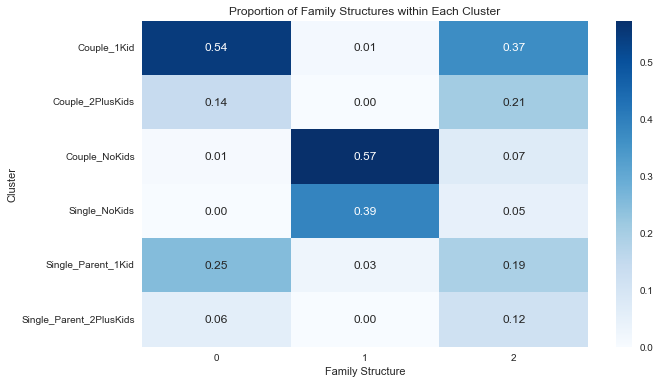

In [127]:
# Function to categorize family structure
def categorize_family_structure(row):
    if row['Is_Parent'] == 1:
        if row['Living_With_Partner'] == 0:
            if row['Children'] == 1:
                return 'Single_Parent_1Kid'
            else:
                return 'Single_Parent_2PlusKids'
        else:
            if row['Children'] == 1:
                return 'Couple_1Kid'
            else:
                return 'Couple_2PlusKids'
    else:
        if row['Living_With_Partner'] == 0:
            return 'Single_NoKids'
        else:
            return 'Couple_NoKids'

# Apply the function to create the new column
data['Family_Structure'] = data.apply(categorize_family_structure, axis=1)

# Calculate the counts of each family structure within each cluster
counts = data.groupby(['Clusters', 'Family_Structure']).size().unstack(fill_value=0)

# Convert counts to proportions
proportions_family = counts.div(counts.sum(axis=1), axis=0)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(proportions_family.T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Proportion of Family Structures within Each Cluster')
plt.xlabel('Family Structure')
plt.ylabel('Cluster')
plt.show()

### 10. Overall User Image
- Cluster 0 (Mid-Spenders)
    - Cluster Distribution: Makes up about a quarter of the total customer base, slightly larger than Cluster 1.
    - Income and Spending: Diverse income and spending levels, with most customers in the mid-income and mid-spending range.
    - Product Preference: Strong preference for wines (60%) and meat products (20%).
    - Purchase Location: Store is the most popular location, with web purchases as a close second.
    - Deal Preference: Diverse approach to deal purchases, benefiting from a mix of regular and deal-based promotions.
    - Customer Tenure: Longest average customer tenure with a broad range, indicating diverse customer retention.
    - Web Engagement: Moderate web engagement.
    - Personal Features:
        - Age: Almost no customers under 30, balanced between middle-aged (30-50) and older (above 50) customers.
        - Family Structure: Dominated by couples with 1 kid and single parents with 1 kid.
- Cluster 1 (High Spenders)
    - Cluster Distribution: Comprises about a quarter of the total customer base, slightly smaller than Cluster 0.
    - Income and Spending: Moderate to high income and spending, indicating more affluent customers.
    - Product Preference: Balanced preference with 44% for wines, 33% for meat products, and 7% for fish.
    - Purchase Location: Balanced location choice, with catalog purchases as the second preference.
    - Deal Preference: Least interest in deals, focusing more on product quality and brand value.
    - Customer Tenure: Intermediate customer tenure.
    - Web Engagement: Lowest web engagement, indicating less frequent online activity.
    - Personal Features:
        - Age: Balanced representation across all age groups.
        - Family Structure: Primarily couples with no kids and single persons with no kids.
- Cluster 2 (Value Seekers)
    - Cluster Distribution: The largest cluster, making up almost half of all customers, indicating a majority with lower incomes and spending.
    - Income and Spending: Low income and low spending, forming a large segment of lower-income customers.
    - Product Preference: Diversified preference with 44% for wines, 23% for meat products, and 15% for gold products.
    - Purchase Location: Store is the most popular location, with web purchases as a close second.
    - Deal Preference: Highly motivated by deals, benefiting most from aggressive deal-based marketing strategies.
    - Customer Tenure: Shorter, more concentrated customer tenure.
    - Web Engagement: Highest web engagement.
    - Personal Features:
        - Age: Predominantly middle-aged (30-50), with a substantial number of older (above 50) and younger (18-30) customers.
        - Family Structure: Diverse mix of family structures, with significant proportions of couples and single parents with varying numbers of kids.

## 11. Overall Actionable Insights
- Cluster 0 (Mid-Spenders)
    - Products and Services: Emphasize wines and meat products in marketing campaigns. Focus on family-oriented products and services. 
    - Marketing Strategies: Target couples with kids and single parents. Implement a mix of regular and promotional deals. Enhance both in-store and online shopping experiences.
- Cluster 1 (High Spenders)
    - Products and Services: Focus on premium products and high-value services. Balance marketing efforts between wines and meat products.
    - Marketing Strategies: Highlight luxury items and exclusive deals. Emphasize convenience and luxury in marketing messages. Invest in both catalog and in-store shopping experiences.
- Cluster 2 (Value Seekers)
    - Products and Services: Offer value-for-money products and budget-friendly options. Highlight wines, meat, and gold products in marketing campaigns.
    - Marketing Strategies: Develop a broad range of family-friendly products. Utilize aggressive discount strategies, flash sales, and loyalty programs. Leverage high web engagement by offering exclusive online promotions and deals. Implement loyalty programs to sustain engagement and potentially increase customer tenure.